In [1]:
import ehrdata as ehr
import numpy as np
import ehrapy as ep
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/envs/ehrdata/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
adata = ehr.io.init_omop(folder_path="/Users/xinyuezhang/BlendedICU/BlendedICU/OMOP-CDM", delimiter=';', use_dask=False)

Checking if your data adheres to the OMOP Common Data Model (CDM) version 5.4 standards.


OMOP Database (OMOP-CDM) with 10 tables.
Clinical data tables: measurement, death, visit_occurrence, person, observation
Health system data tables: care_site, location
Vocabulary tables: source_to_concept_map, concept, domain

2024-03-03 14:32:45,776 - root INFO - Transformed passed DataFrame into an AnnData object with n_obs x n_vars = `328680` x `0`.


In [4]:
adata.obs['data_source'] = adata.obs['person_source_value'].str.split('-').str[0]
adata

AnnData object with n_obs × n_vars = 328680 × 0
    obs: 'visit_start_date', 'year_of_birth', 'admitted_from_source_value', 'person_source_value', 'visit_end_date', 'gender_source_value', 'person_id', 'visit_start_datetime', 'birth_datetime', 'visit_end_datetime', 'discharged_to_source_value', 'visit_type_concept_id', 'location_id', 'visit_source_value', 'visit_concept_id', 'gender_concept_id', 'data_source'
    var: 'ehrapy_column_type'
    uns: 'filepath_dict', 'tables', 'delimiter', 'use_dask'
    layers: 'original'

## Get ETHNICITY info

ETHNICITY is recored on Patient level for eICU

In [7]:
df = adata[adata.obs['data_source'] == 'eicu'].obs[['person_source_value']].reset_index()
df.person_source_value = df.person_source_value.str.removeprefix('eicu-')

df_source = pd.read_csv("/Users/xinyuezhang/physionet.org/files/eicu-crd/2.0/patient.csv.gz")
df_source = df_source[['uniquepid', 'ethnicity']].dropna().drop_duplicates(subset='uniquepid', keep='first')
df = pd.merge(df, df_source, how='left', left_on= 'person_source_value', right_on='uniquepid')
df.ethnicity.fillna('Other/Unknown', inplace=True)
df_eicu = df[['visit_occurrence_id', 'ethnicity']]

ETHNICITY is recored on visit level for MIMIC-III

In [8]:
df = adata[adata.obs['data_source'] == 'mimic3'].obs[['person_source_value']].reset_index()
df.person_source_value = df.person_source_value.str.removeprefix('mimic3-').astype(int)

df_source = pd.read_csv("/Users/xinyuezhang/physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz")
df_source = df_source[['SUBJECT_ID', 'ETHNICITY']].dropna().drop_duplicates(subset='SUBJECT_ID', keep='first')
df = pd.merge(df, df_source, how='left', left_on= 'person_source_value', right_on='SUBJECT_ID')
df.rename(columns = {"ETHNICITY": 'ethnicity'}, inplace=True)
df_mimic3 = df[['visit_occurrence_id', 'ethnicity']]


ETHNICITY is recored on visit level for MIMIC-IV

In [9]:
df = adata[adata.obs['data_source'] == 'mimic4'].obs[['person_source_value']].reset_index()
df.person_source_value = df.person_source_value.str.removeprefix('mimic4-').astype(int)
df_source = pd.read_csv("/Users/xinyuezhang/physionet.org/files/mimiciv/2.2/hosp/admissions.csv.gz")
df_source = df_source[['subject_id', 'race']].dropna().drop_duplicates(subset='subject_id', keep='first')
df = pd.merge(df, df_source, how='left', left_on= 'person_source_value', right_on='subject_id')
df.rename(columns = {"race": 'ethnicity'}, inplace=True)
df_mimic4 =  df[['visit_occurrence_id', 'ethnicity']]


In [13]:
df = pd.concat([df_eicu, df_mimic3, df_mimic4])
adata.obs = pd.merge(adata.obs, df, how='left', left_index=True, right_on='visit_occurrence_id').set_index('visit_occurrence_id')

In [ ]:

# Simplification mapping
simplification_dict = {
    'Caucasian': 'White',
    'African American': 'Black/African American',
    'Other/Unknown': 'Other',
    'Native American': 'Native American',
    'Asian': 'Asian',
    'Hispanic': 'Hispanic/Latino',
    'WHITE': 'White',
    'OTHER': 'Other',
    'BLACK/AFRICAN AMERICAN': 'Black/African American',
    'UNKNOWN/NOT SPECIFIED': 'Other',
    'BLACK/HAITIAN': 'Black/African American',
    'PORTUGUESE': 'White',
    'WHITE - EASTERN EUROPEAN': 'White',
    'PATIENT DECLINED TO ANSWER': 'Other',
    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'UNABLE TO OBTAIN': 'Other',
    'WHITE - RUSSIAN': 'White',
    'BLACK/AFRICAN': 'Black/African American',
    'CARIBBEAN ISLAND': 'Other',
    'MULTI RACE ETHNICITY': 'Multi Race/Ethnicity',
    'AMERICAN INDIAN/ALASKA NATIVE': 'Native American',
    'SOUTH AMERICAN': 'Hispanic/Latino',
    'WHITE - BRAZILIAN': 'White',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'Pacific Islander',
    'MIDDLE EASTERN': 'Other',
    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE': 'Native American',
    'MULTIPLE RACE/ETHNICITY': 'Multi Race/Ethnicity',
    'UNKNOWN': 'Other',
    'BLACK/CARIBBEAN ISLAND': 'Black/African American'
}

categories = list(adata.obs.ethnicity.unique())
for category in categories:
    if category.startswith("ASIAN"):
        simplification_dict[category] = 'Asian'
    elif "HISPANIC/LATINO" in category:
        simplification_dict[category] = 'Hispanic/Latino'


adata.obs['ethnicity_simplified'] = adata.obs['ethnicity'].replace(simplification_dict)

## Get insurance info

In [52]:
df = adata[adata.obs['data_source'] == 'mimic3'].obs[['person_source_value']].reset_index()
df.person_source_value = df.person_source_value.str.removeprefix('mimic3-').astype(int)
df_source = pd.read_csv("/Users/xinyuezhang/physionet.org/files/mimiciii/1.4/ADMISSIONS.csv.gz")
df_source = df_source[['SUBJECT_ID', 'INSURANCE']].dropna().drop_duplicates(subset='SUBJECT_ID', keep='first')
df = pd.merge(df, df_source, how='left', left_on= 'person_source_value', right_on='SUBJECT_ID')
df.rename(columns = {"INSURANCE": 'insurance'}, inplace=True)
df_mimic3 = df[['visit_occurrence_id', 'insurance']]


In [54]:
df = adata[adata.obs['data_source'] == 'mimic4'].obs[['person_source_value']].reset_index()
df.person_source_value = df.person_source_value.str.removeprefix('mimic4-').astype(int)
df_source = pd.read_csv("/Users/xinyuezhang/physionet.org/files/mimiciv/2.2/hosp/admissions.csv.gz")
df_source = df_source[['subject_id', 'insurance']].dropna().drop_duplicates(subset='subject_id', keep='first')
df = pd.merge(df, df_source, how='left', left_on= 'person_source_value', right_on='subject_id')
df_mimic4 =  df[['visit_occurrence_id', 'insurance']]


In [56]:
df = pd.concat([df_mimic3, df_mimic4])
adata.obs = pd.merge(adata.obs, df, how='left', left_index=True, right_on='visit_occurrence_id').set_index('visit_occurrence_id')

# Feature statistics

Couldn't find concept [44804452, 3711521] in concept table!

feature_name  observation_concept_id   count
0     44804452                44804452  328680
1      3711521                 3711521  328680
2  Body height                  607590  328680

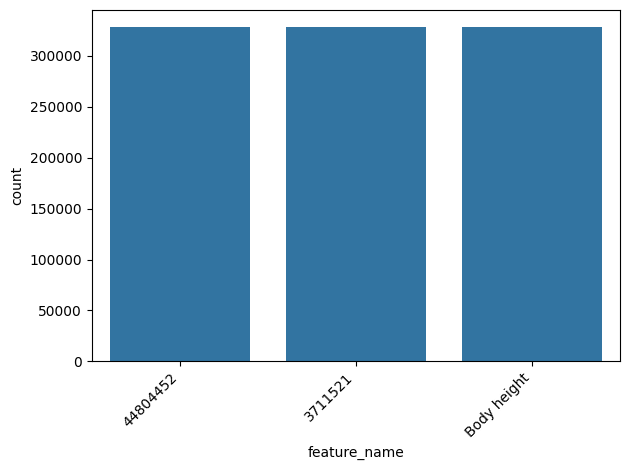

In [12]:
ehr.pl.feature_counts(adata, source='observation', number=20)

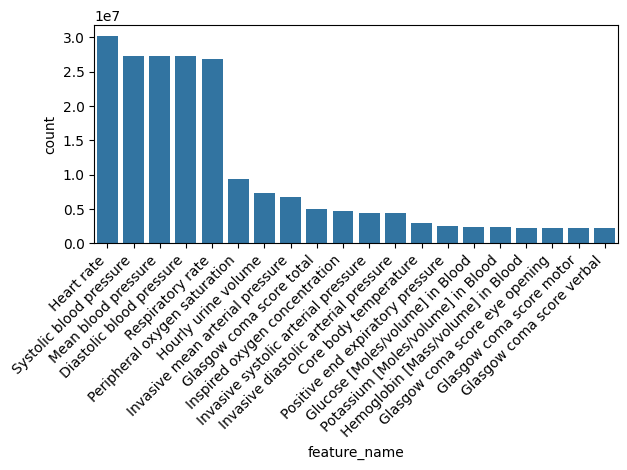

In [16]:
feature_count_df = ehr.pl.feature_counts(adata, source='measurement', number=20)

In [17]:
observation_features = ['Body weight']
measurement_features = feature_count_df.feature_name.tolist()

In [18]:
adata = ehr.pp.get_feature_statistics(adata, add_aggregation_to_X=True, aggregation_methods='mean', source='measurement', level='stay_level', features=measurement_features, verbose=True)

Detected: feature Heart rate, feature ID 4239408 in concept table, match ratio = 100.

Detected: feature Systolic blood pressure, feature ID 4152194 in concept table, match ratio = 100.

Detected: feature Mean blood pressure, feature ID 4239021 in concept table, match ratio = 100.

Detected: feature Diastolic blood pressure, feature ID 4154790 in concept table, match ratio = 100.

Detected: feature Respiratory rate, feature ID 4313591 in concept table, match ratio = 100.

Detected: feature Peripheral oxygen saturation, feature ID 4196147 in concept table, match ratio = 100.

Detected: feature Hourly urine volume, feature ID 4145209 in concept table, match ratio = 100.

Detected: feature Invasive mean arterial pressure, feature ID 4108290 in concept table, match ratio = 100.

Detected: feature Glasgow coma score total, feature ID 3007194 in concept table, match ratio = 100.

Detected: feature Inspired oxygen concentration, feature ID 4353936 in concept table, match ratio = 100.

Detected: feature Invasive systolic arterial pressure, feature ID 4353843 in concept table, match ratio = 100.

Detected: feature Invasive diastolic arterial pressure, feature ID 4354253 in concept table, match ratio = 100.

Detected: feature Core body temperature, feature ID 4174894 in concept table, match ratio = 100.

Detected: feature Positive end expiratory pressure, feature ID 4353713 in concept table, match ratio = 100.

Detected: feature Glucose [Moles/volume] in Blood, feature ID 3020491 in concept table, match ratio = 100.

Detected: feature Potassium [Moles/volume] in Blood, feature ID 3005456 in concept table, match ratio = 100.

Detected: feature Hemoglobin [Mass/volume] in Blood, feature ID 3000963 in concept table, match ratio = 100.

Detected: feature Glasgow coma score eye opening, feature ID 3016335 in concept table, match ratio = 100.

Detected: feature Glasgow coma score motor, feature ID 3008223 in concept table, match ratio = 100.

Detected: feature Glasgow coma score verbal, feature ID 3009094 in concept table, match ratio = 100.

Calculating statistics
2024-03-03 14:38:27,167 - root INFO - Added `['Heart rate_mean', 'Systolic blood pressure_mean', 'Mean blood pressure_mean', 'Diastolic blood pressure_mean', 'Respiratory rate_mean', 'Peripheral oxygen saturation_mean', 'Hourly urine volume_mean', 'Invasive mean arterial pressure_mean', 'Glasgow coma score total_mean', 'Inspired oxygen concentration_mean', 'Invasive systolic arterial pressure_mean', 'Invasive diastolic arterial pressure_mean', 'Core body temperature_mean', 'Positive end expiratory pressure_mean', 'Glucose [Moles/volume] in Blood_mean', 'Potassium [Moles/volume] in Blood_mean', 'Hemoglobin [Mass/volume] in Blood_mean', 'Glasgow coma score eye opening_mean', 'Glasgow coma score motor_mean', 'Glasgow coma score verbal_mean']` features to `X`.


In [19]:
adata.X

array([[         nan,  63.77241379,          nan, ...,   4.34444427,
         24.59701493, 130.62068966],
       [         nan,  59.42748092,          nan, ...,   3.84000015,
         17.95061728, 136.5648855 ],
       [         nan,  92.73134328,          nan, ...,   3.79999995,
         18.17857143, 169.68656716],
       ...,
       [ 36.77777863,  70.25      ,   3.        , ...,   3.56666692,
         16.64516129, 132.        ],
       [ 36.81296387,  80.02702703,   4.        , ...,   4.17500019,
         15.42857143, 139.54054054],
       [ 36.83333193,  83.22680412,   3.30232558, ...,   3.64000015,
         16.8852459 , 144.07142857]])

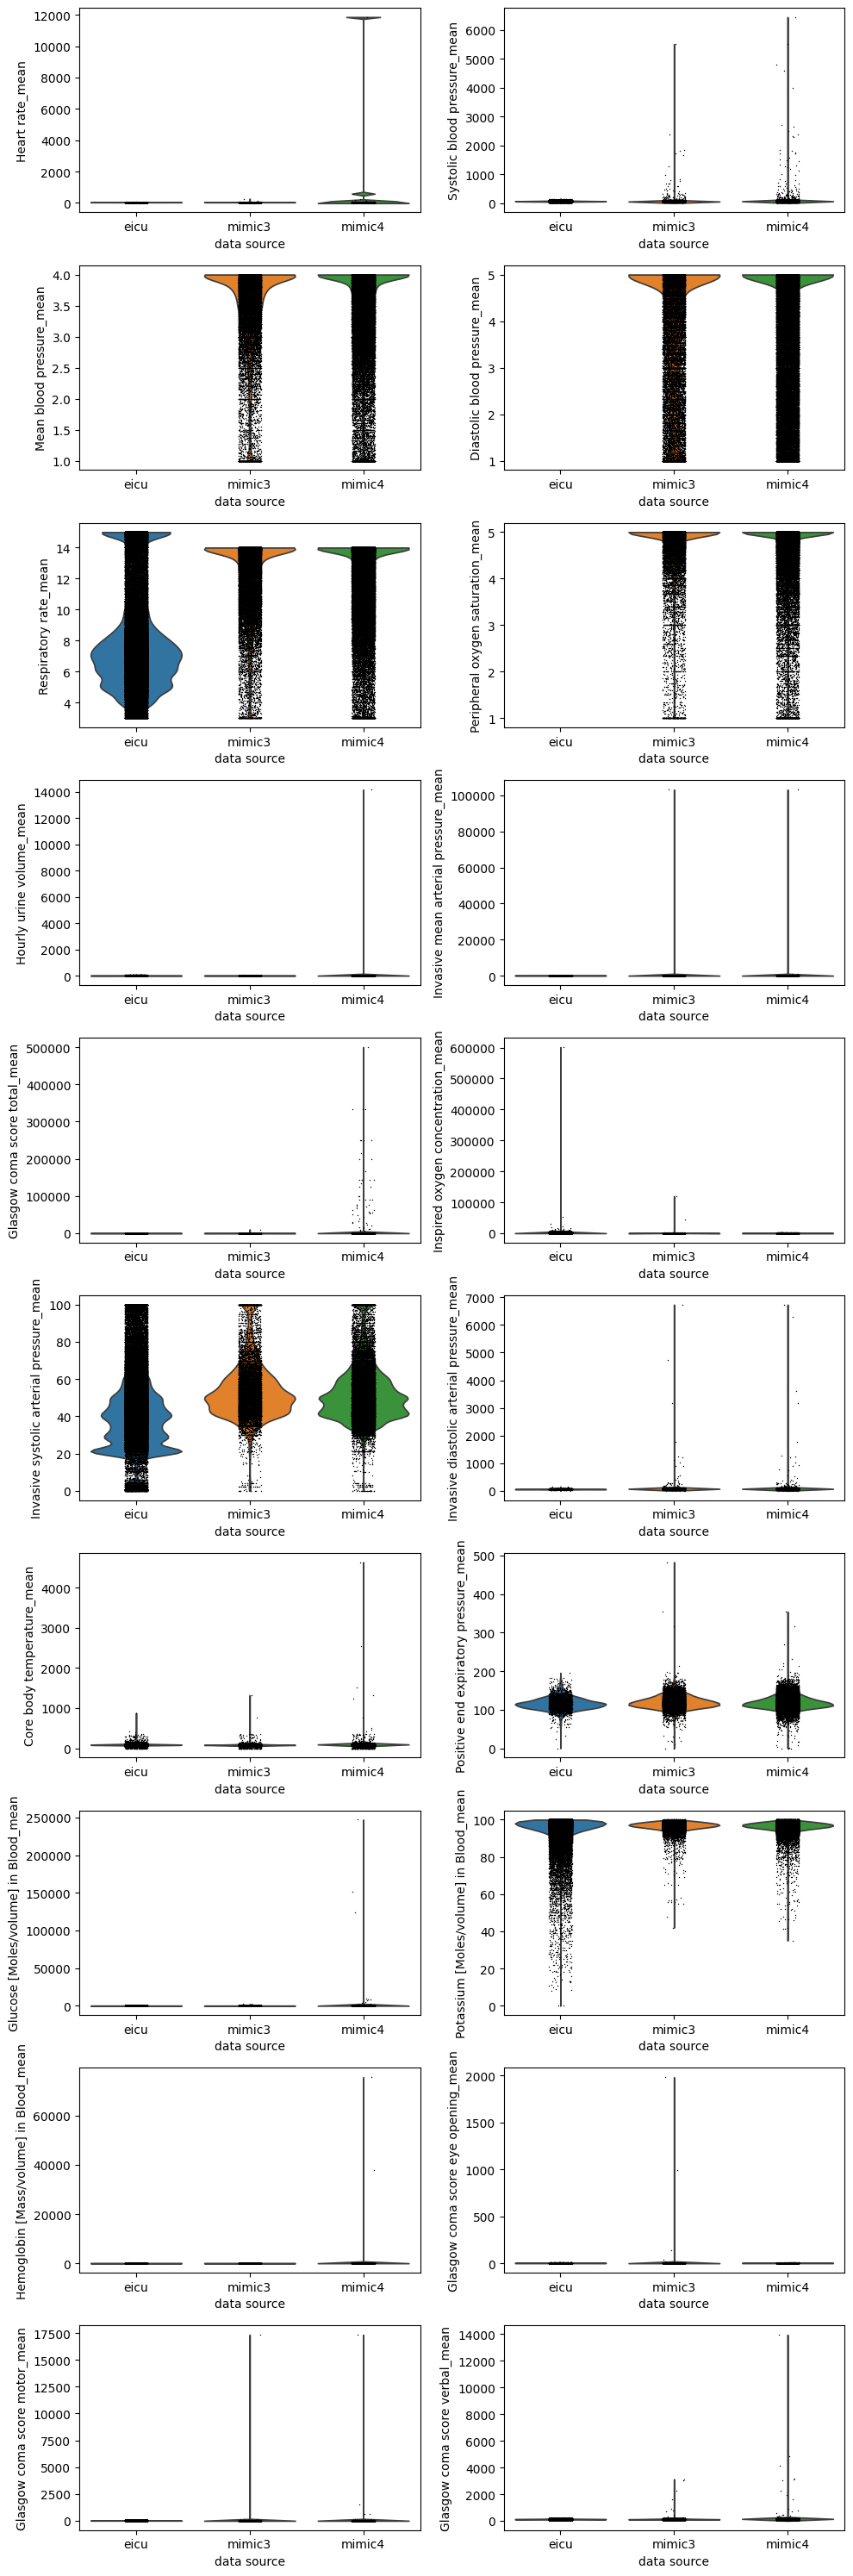

In [ ]:
#adata.X = adata.X.astype(float)
fig = plt.figure(figsize=(10, 30))
for i, variable in enumerate(measurement_features, start=1):
    ax = plt.subplot(10, 2, i)
    ehr.pl.violin(adata, keys=f'{variable}_mean', groupby='data_source', ax=ax, show=False)
fig.tight_layout()
plt.show()

In [8]:
measurements = ['Heart rate_mean',
 'Systolic blood pressure_mean',
  'Hourly urine volume_mean',
  'Invasive mean arterial pressure_mean',
  'Core body temperature_mean',
  'Glasgow coma score total_mean',
  'Glasgow coma score eye opening_mean',
 'Glasgow coma score motor_mean',
 'Glasgow coma score verbal_mean',
 'Invasive diastolic arterial pressure_mean',
 'Glucose [Moles/volume] in Blood_mean',
  ]
reference_table = pd.DataFrame(
    np.array(
        [
        "0-300",    # Heart rate_mean (beats per minute)
        "0-300",    # Systolic blood pressure_mean (mmHg)
        "0-2000",   # Hourly urine volume_mean (ml/hour) - to accommodate diuresis
        "0-500",    # Invasive mean arterial pressure_mean (mmHg)
        "0-500",    # Core body temperature_mean (°C) - accommodating hypothermia to hyperthermia
        "1-100",      
        "1-100",      
        "1-100",      
        "1-100",
        "0-500",    # Invasive diastolic arterial pressure_mean (mmHg)
        "0-400",     # Glucose [Moles/volume] in Blood_mean (mmol/L) - very wide to accommodate severe cases
        ]

    ),
    columns=["Traditional Reference Interval"],
    index=measurements,
)
reference_table

Traditional Reference Interval
Heart rate_mean                                                    0-300
Systolic blood pressure_mean                                       0-300
Hourly urine volume_mean                                          0-2000
Invasive mean arterial pressure_mean                               0-500
Core body temperature_mean                                         0-500
Glasgow coma score total_mean                                      1-100
Glasgow coma score eye opening_mean                                1-100
Glasgow coma score motor_mean                                      1-100
Glasgow coma score verbal_mean                                     1-100
Invasive diastolic arterial pressure_mean                          0-500
Glucose [Moles/volume] in Blood_mean                               0-400

In [9]:
ehr.pp.qc_lab_measurements(adata, measurements=measurements, reference_table=reference_table, verbose=True)

Detected Heart rate_mean for Heart rate_mean with score 100.

Using minimum of 0.0 and maximum of 300.0

Detected Systolic blood pressure_mean for Systolic blood pressure_mean with score 100.

Using minimum of 0.0 and maximum of 300.0

Detected Hourly urine volume_mean for Hourly urine volume_mean with score 100.

Using minimum of 0.0 and maximum of 2000.0

Detected Invasive mean arterial pressure_mean for Invasive mean arterial pressure_mean with score 100.

Using minimum of 0.0 and maximum of 500.0

Detected Core body temperature_mean for Core body temperature_mean with score 100.

Using minimum of 0.0 and maximum of 500.0

Detected Glasgow coma score total_mean for Glasgow coma score total_mean with score 100.

Using minimum of 1.0 and maximum of 100.0

Detected Glasgow coma score eye opening_mean for Glasgow coma score eye opening_mean with score 100.

Using minimum of 1.0 and maximum of 100.0

Detected Glasgow coma score motor_mean for Glasgow coma score motor_mean with score 100.

Using minimum of 1.0 and maximum of 100.0

Detected Glasgow coma score verbal_mean for Glasgow coma score verbal_mean with score 100.

Using minimum of 1.0 and maximum of 100.0

Detected Invasive diastolic arterial pressure_mean for Invasive diastolic arterial pressure_mean with score 100.

Using minimum of 0.0 and maximum of 500.0

Detected Glucose [Moles/volume] in Blood_mean for Glucose [Moles/volume] in Blood_mean with score 100.

Using minimum of 0.0 and maximum of 400.0

In [10]:
for measurement in measurements:
    adata = adata[adata.obs[f"{measurement} normal"]]

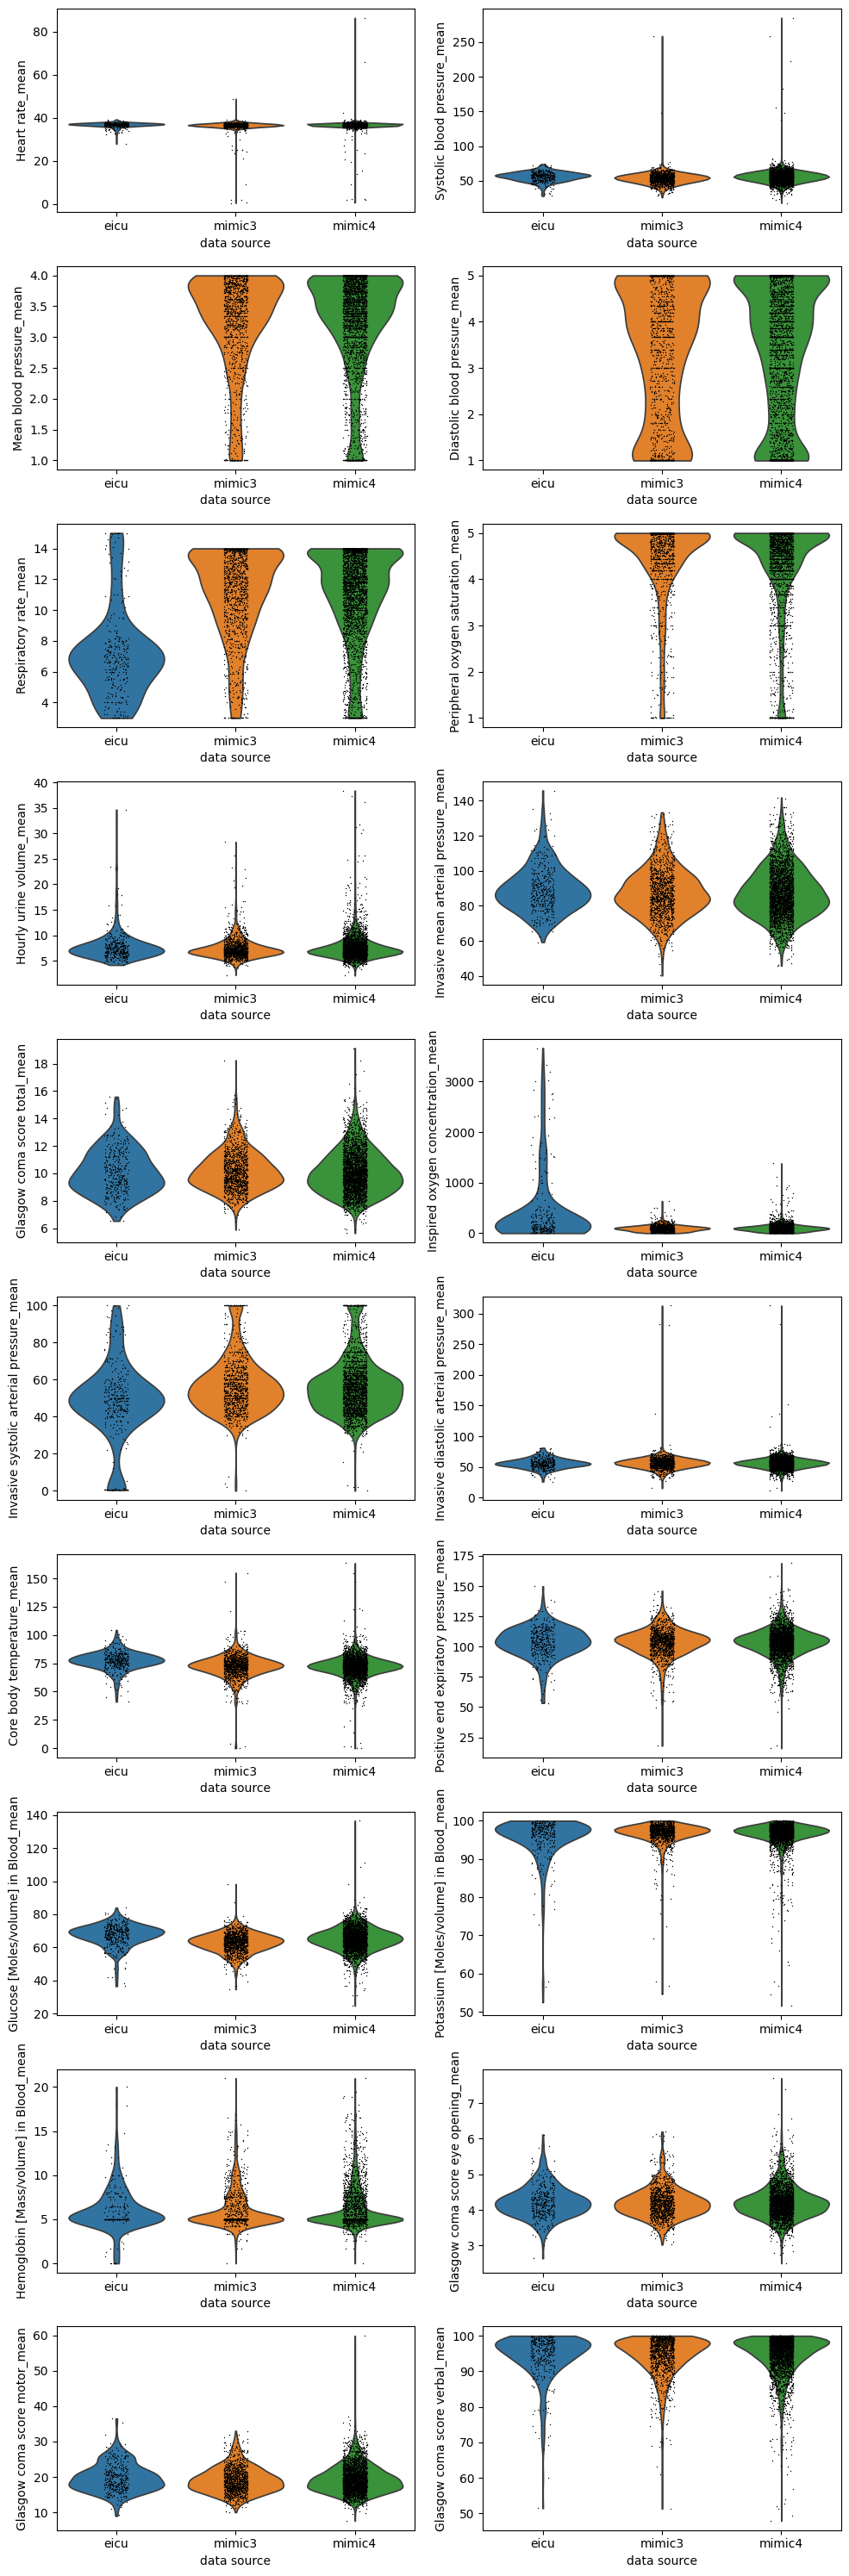

In [12]:
fig = plt.figure(figsize=(10, 30))
for i, variable in enumerate(measurement_features, start=1):
    ax = plt.subplot(10, 2, i)
    ehr.pl.violin(adata, keys=f'{variable}_mean', groupby='data_source', ax=ax, show=False)
fig.tight_layout()
plt.show()

<Axes: xlabel='nan_count_X', ylabel='Count'>

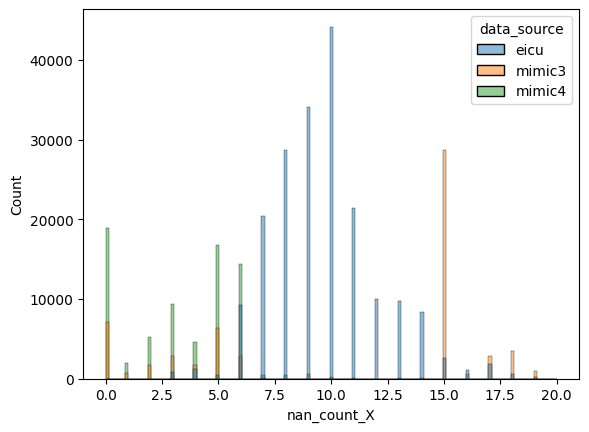

In [8]:
nan_count_list = np.sum(np.isnan(adata.X), axis=1).tolist()
adata.obs['nan_count_X'] = nan_count_list

sns.histplot(data=adata.obs, x = 'nan_count_X', hue='data_source')

remove these three features because eICU doesn't have these

In [9]:
adata = adata[:, ~adata.var_names.isin(['Mean blood pressure_mean', 'Diastolic blood pressure_mean', 'Peripheral oxygen saturation_mean'])]
adata.layers['original'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 328680 × 17
    obs: 'visit_start_datetime', 'visit_start_date', 'visit_concept_id', 'visit_source_value', 'location_id', 'visit_type_concept_id', 'visit_end_date', 'visit_end_datetime', 'discharged_to_source_value', 'admitted_from_source_value', 'person_id', 'gender_concept_id', 'year_of_birth', 'person_source_value', 'gender_source_value', 'birth_datetime', 'data_source', 'nan_count_X'
    var: 'ehrapy_column_type'
    uns: 'filepath_dict', 'tables', 'delimiter', 'use_dask'
    layers: 'original'

## Using different Imputation Methods

In [20]:
adata.X = np.where(adata.X < 0, 0, adata.X)

Quality control metrics missing. Calculating...

Feature Mean blood pressure_mean had more than 70.77% missing values!

Feature Heart rate_mean had more than 70.10% missing values!

Feature Peripheral oxygen saturation_mean had more than 70.77% missing values!

Feature Diastolic blood pressure_mean had more than 70.77% missing values!

Feature Hemoglobin [Mass/volume] in Blood_mean had more than 73.83% missing values!

Feature Positive end expiratory pressure_mean had more than 87.64% missing values!

Feature Core body temperature_mean had more than 75.10% missing values!

Feature Invasive diastolic arterial pressure_mean had more than 87.64% missing values!

2024-03-03 14:38:34,077 - root INFO - Values in columns ['Heart rate_mean', 'Systolic blood pressure_mean', 'Mean blood pressure_mean', 'Diastolic blood pressure_mean', 'Respiratory rate_mean', 'Peripheral oxygen saturation_mean', 'Hourly urine volume_mean', 'Invasive mean arterial pressure_mean', 'Glasgow coma score total_mean', 'Inspired oxygen concentration_mean', 'Invasive systolic arterial pressure_mean', 'Invasive diastolic arterial pressure_mean', 'Core body temperature_mean', 'Positive end expiratory pressure_mean', 'Glucose [Moles/volume] in Blood_mean', 'Potassium [Moles/volume] in Blood_mean', 'Hemoglobin [Mass/volume] in Blood_mean', 'Glasgow coma score eye opening_mean', 'Glasgow coma score motor_mean', 'Glasgow coma score verbal_mean'] were replaced by [[3.635599   4.1708798  1.51139635 ... 1.67605757 3.24247574 4.87992422]
 [3.635599   4.10144398 1.51139635 ... 1.57691475 2.94183651 4.9240957 ]
 [3.635599   4.54043264 1.51139635 ... 1.56861591 2.95379358 5.13982893]
 ...

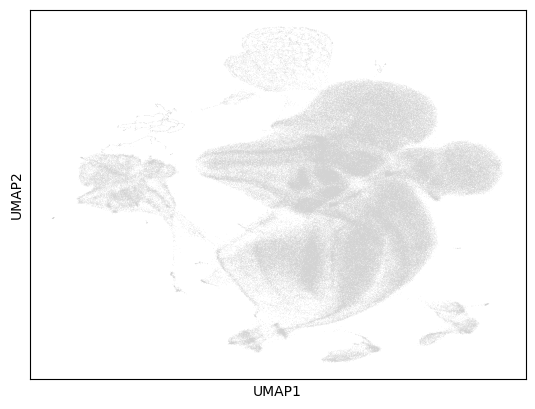

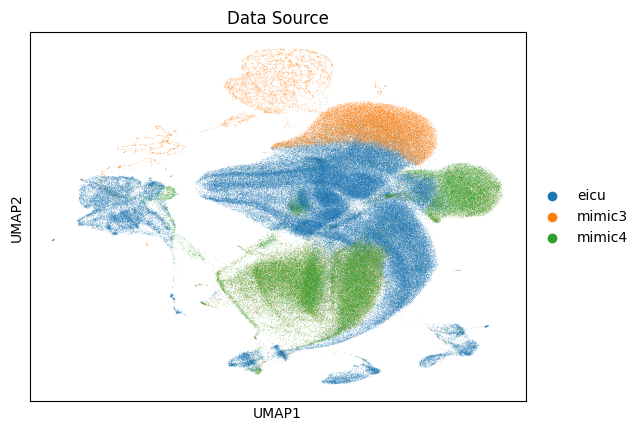

In [21]:
ep.pp.simple_impute(adata, strategy='mean')
ep.pp.log_norm(adata, offset=1)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.pl.umap(adata)
ep.pl.umap(adata, color=["data_source"], wspace=0.5, title=["Data Source"])

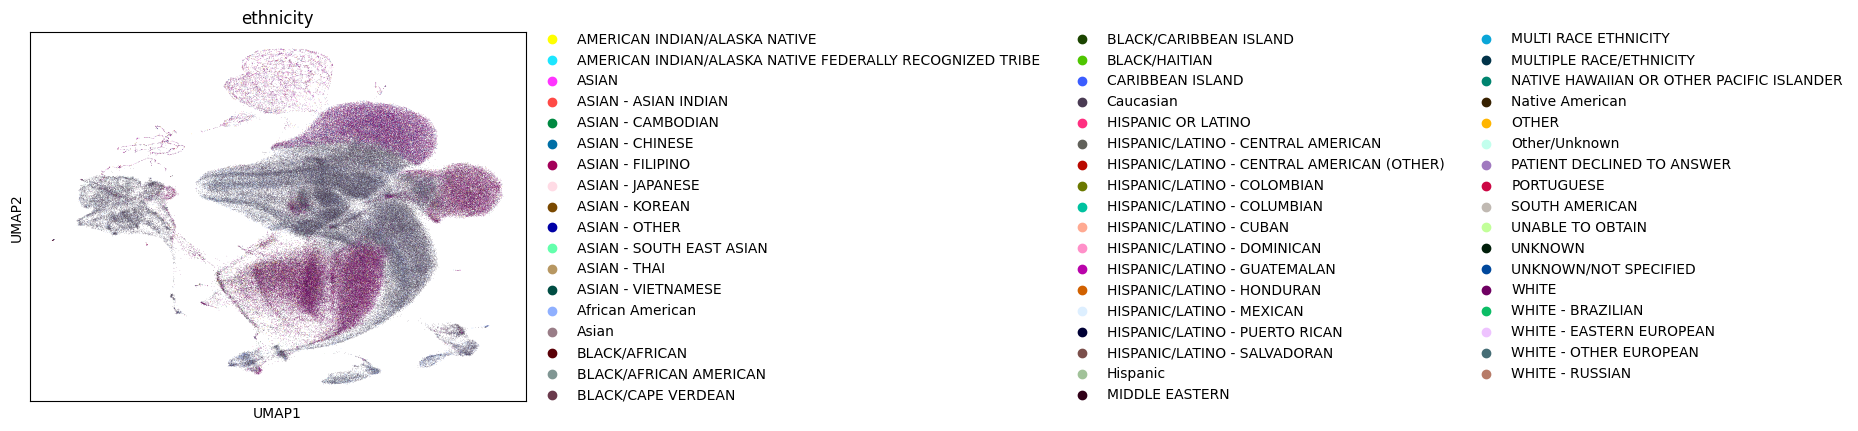

In [22]:
ep.pl.umap(adata, color=["ethnicity"], wspace=0.5, title=["ethnicity"])

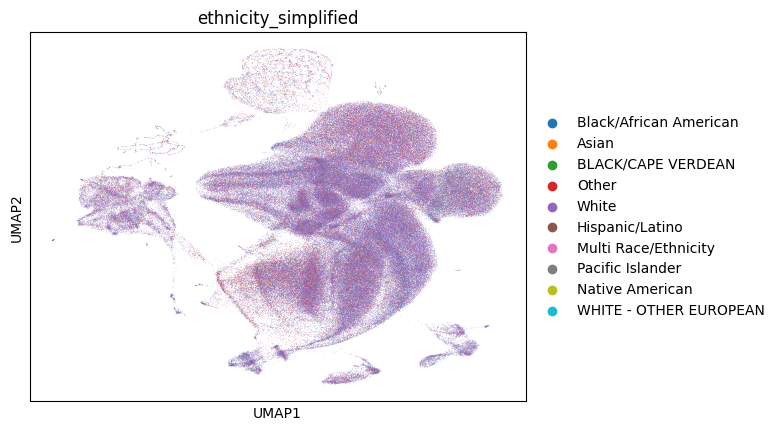

In [42]:
ep.pl.umap(adata, color=["ethnicity_simplified"], wspace=0.5, title=["ethnicity_simplified"])

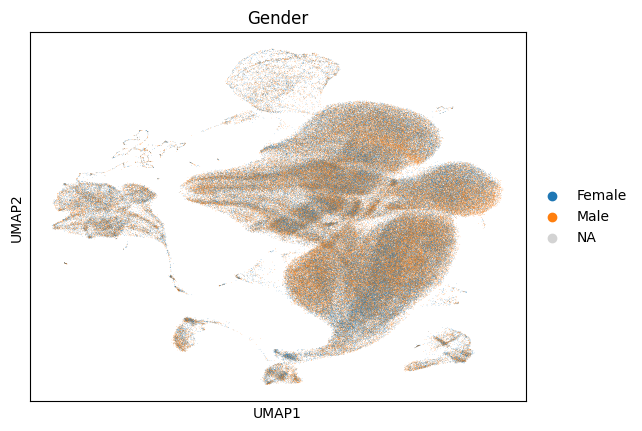

In [13]:
adata.obs['gender'] = adata.obs['gender_source_value'].map({0: 'Female', 1: "Male"})
ep.pl.umap(adata, color=["gender"], wspace=0.5, title=["Gender"])

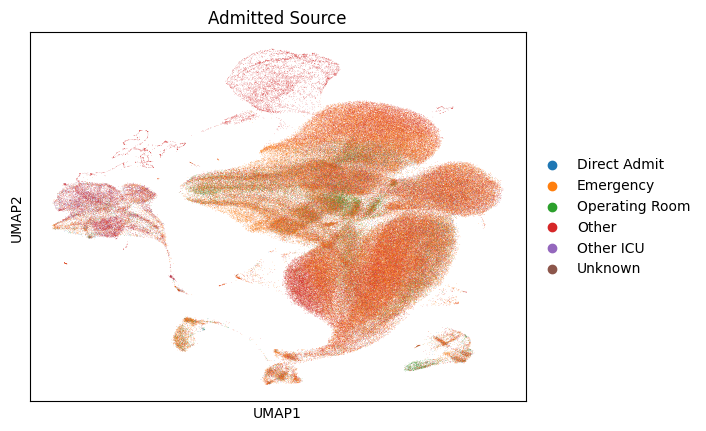

In [14]:
ep.pl.umap(adata, color=["admitted_from_source_value"], wspace=0.5, title=["Admitted Source"])

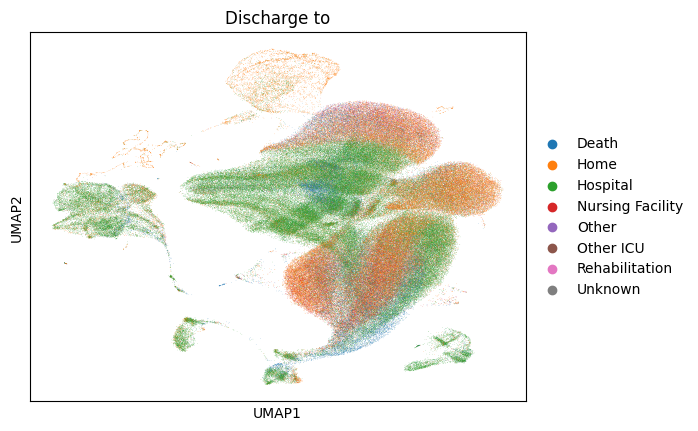

In [15]:
ep.pl.umap(adata, color=["discharged_to_source_value"], wspace=0.5, title=["Discharge to"])

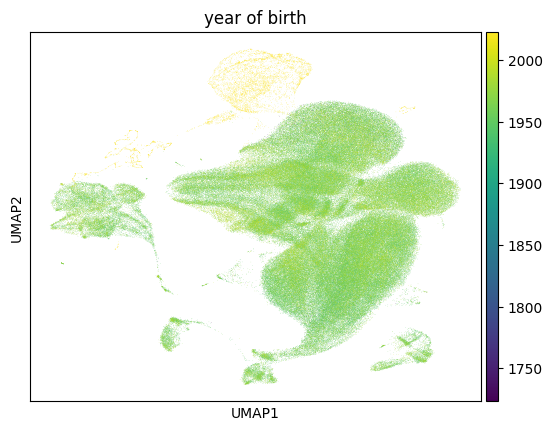

In [16]:
ep.pl.umap(adata, color=["year_of_birth"], wspace=0.5, title=["year of birth"])

Feature Mean blood pressure_mean had more than 70.77% missing values!

Feature Heart rate_mean had more than 70.10% missing values!

Feature Peripheral oxygen saturation_mean had more than 70.77% missing values!

Feature Diastolic blood pressure_mean had more than 70.77% missing values!

Feature Hemoglobin [Mass/volume] in Blood_mean had more than 73.83% missing values!

Feature Positive end expiratory pressure_mean had more than 87.64% missing values!

Feature Core body temperature_mean had more than 75.10% missing values!

Feature Invasive diastolic arterial pressure_mean had more than 87.64% missing values!

2024-03-03 17:08:08,121 - root INFO - Values in columns ['Heart rate_mean', 'Systolic blood pressure_mean', 'Mean blood pressure_mean', 'Diastolic blood pressure_mean', 'Respiratory rate_mean', 'Peripheral oxygen saturation_mean', 'Hourly urine volume_mean', 'Invasive mean arterial pressure_mean', 'Glasgow coma score total_mean', 'Inspired oxygen concentration_mean', 'Invasive systolic arterial pressure_mean', 'Invasive diastolic arterial pressure_mean', 'Core body temperature_mean', 'Positive end expiratory pressure_mean', 'Glucose [Moles/volume] in Blood_mean', 'Potassium [Moles/volume] in Blood_mean', 'Hemoglobin [Mass/volume] in Blood_mean', 'Glasgow coma score eye opening_mean', 'Glasgow coma score motor_mean', 'Glasgow coma score verbal_mean'] were replaced by [[1.53153609 1.6182356  0.95507127 ... 0.98441528 1.40356829 1.72917121]
 [1.53376543 1.65012727 0.92083891 ... 0.92232339 1.42661103 1.75919489]
 [1.53376543 1.65012727 0.92083891 ... 0.94739346 1.39114478 1.75919489]
 ...

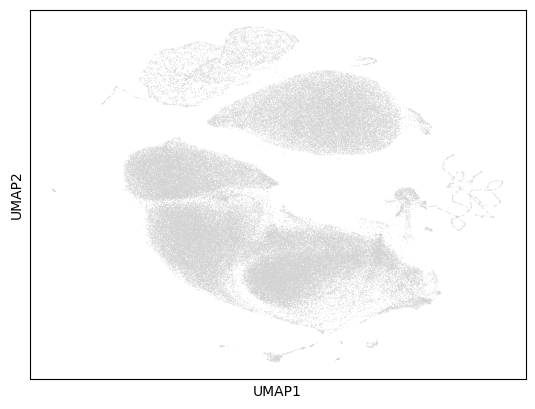

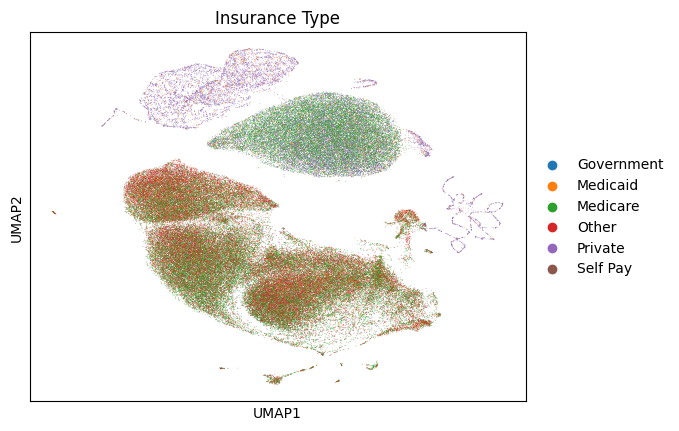

In [61]:
adata_mimic = adata[adata.obs['data_source']!= 'eicu']
ep.pp.simple_impute(adata_mimic, strategy='mean')
ep.pp.log_norm(adata_mimic, offset=1)
ep.pp.neighbors(adata_mimic)
ep.tl.umap(adata_mimic)
ep.pl.umap(adata_mimic)
ep.pl.umap(adata_mimic, color=["insurance"], wspace=0.5, title=["Insurance Type"])

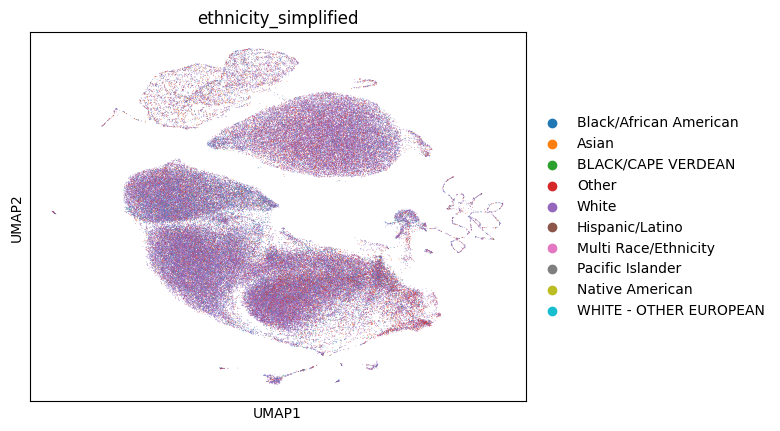

In [62]:
ep.pl.umap(adata_mimic, color=["ethnicity_simplified"], wspace=0.5, title=["ethnicity_simplified"])

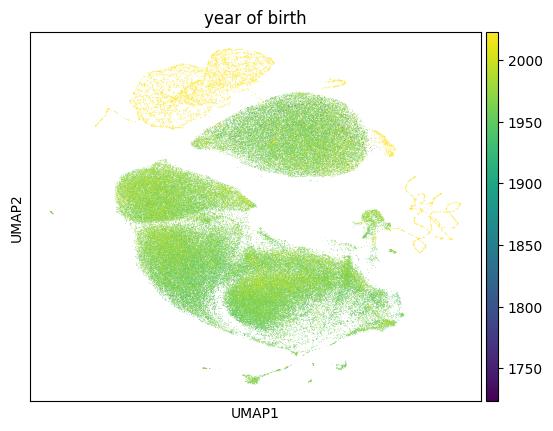

In [63]:
ep.pl.umap(adata_mimic, color=["year_of_birth"], wspace=0.5, title=["year of birth"])

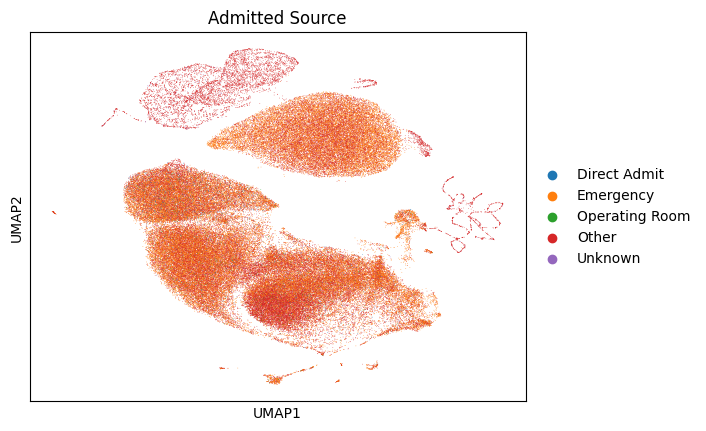

In [65]:
ep.pl.umap(adata_mimic, color=["admitted_from_source_value"], wspace=0.5, title=["Admitted Source"])

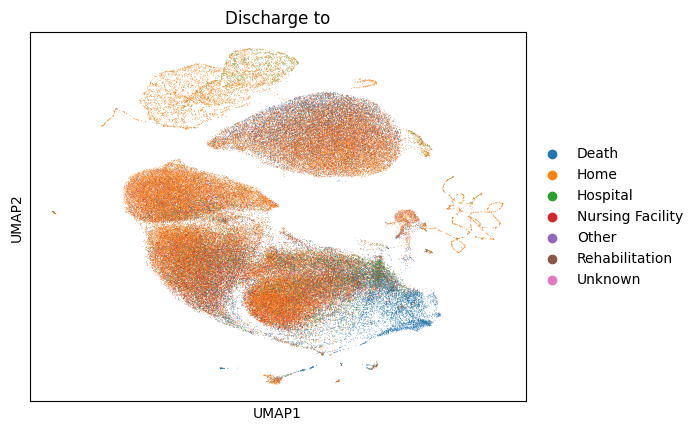

In [64]:
ep.pl.umap(adata_mimic, color=["discharged_to_source_value"], wspace=0.5, title=["Discharge to"])

In [149]:
adata.X = adata.layers['original']
adata.X = np.where(adata.X < 0, 0, adata.X)
ep.pp.explicit_impute(adata, replacement=0)
ep.pp.log_norm(adata, offset=1)
ep.pp.neighbors(adata)
ep.tl.umap(adata)
ep.pl.umap(adata)
ep.pl.umap(adata, color=["data_source"], wspace=0.5, title=["Data Source"])

Feature Positive end expiratory pressure_mean had more than 87.64% missing values!

Feature Core body temperature_mean had more than 75.10% missing values!

Feature Invasive diastolic arterial pressure_mean had more than 87.64% missing values!

Feature Hemoglobin [Mass/volume] in Blood_mean had more than 73.83% missing values!

Feature Heart rate_mean had more than 70.10% missing values!

2024-03-01 12:00:02,343 - root INFO - Values in columns ['Heart rate_mean', 'Systolic blood pressure_mean', 'Respiratory rate_mean', 'Hourly urine volume_mean', 'Invasive mean arterial pressure_mean', 'Glasgow coma score total_mean', 'Inspired oxygen concentration_mean', 'Invasive systolic arterial pressure_mean', 'Invasive diastolic arterial pressure_mean', 'Core body temperature_mean', 'Positive end expiratory pressure_mean', 'Glucose [Moles/volume] in Blood_mean', 'Potassium [Moles/volume] in Blood_mean', 'Hemoglobin [Mass/volume] in Blood_mean', 'Glasgow coma score eye opening_mean', 'Glasgow coma score motor_mean', 'Glasgow coma score verbal_mean'] were replaced by [[0.         4.1708798  2.12212227 ... 1.67605757 3.24247574 4.87992422]
 [0.         4.10144398 2.1654254  ... 1.57691475 2.94183651 4.9240957 ]
 [0.         4.54043264 2.21920348 ... 1.56861591 2.95379358 5.13982893]
 ...
 [3.63172106 4.26619482 2.4510051  ... 1.5187836  2.8704616  4.89034913]
 [3.632652   4.39478277 

KeyboardInterrupt: 